In [62]:
from cleaning_t import *

In [29]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing
from collections import Counter
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


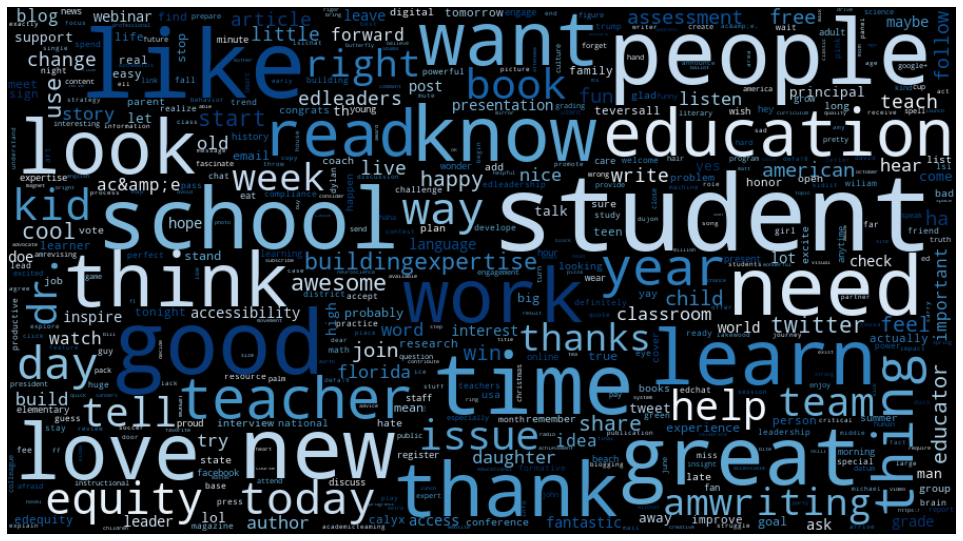

CPU times: user 517 ms, sys: 6.34 ms, total: 523 ms
Wall time: 526 ms
(1231, 732)


array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [31]:
def open_data(file):
    df = pd.read_csv(file)
    return df

tweets_user = open_data('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@maialee_tweets.csv')


def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

tweets_user['RT'] = tweets_user.text.apply(retweet)

tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

tweets_user['date'] = tweets_user['created_at']

tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

nlp = spacy.load('en')

parser = English()

nlp.Defaults.stop_words |= {"rt","amp","xx", "xxx"}


def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_user['tokenized']: # try 'tokens'
    all_words.extend(line)
    
wordfreq = Counter(all_words)

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

array_matrix = tfidf_matrix.toarray()

first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

vocab = tfidf_vectorizer.vocabulary_

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

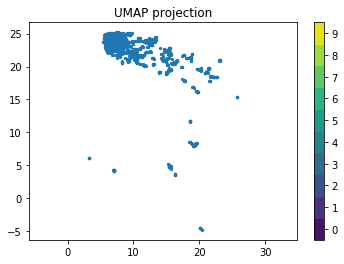

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import umap

umap = UMAP(n_components=2, n_neighbors=8)
embedding = umap.fit_transform(dist)

umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

umap_df.head()

plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);


Silhouette Coefficient: 0.345


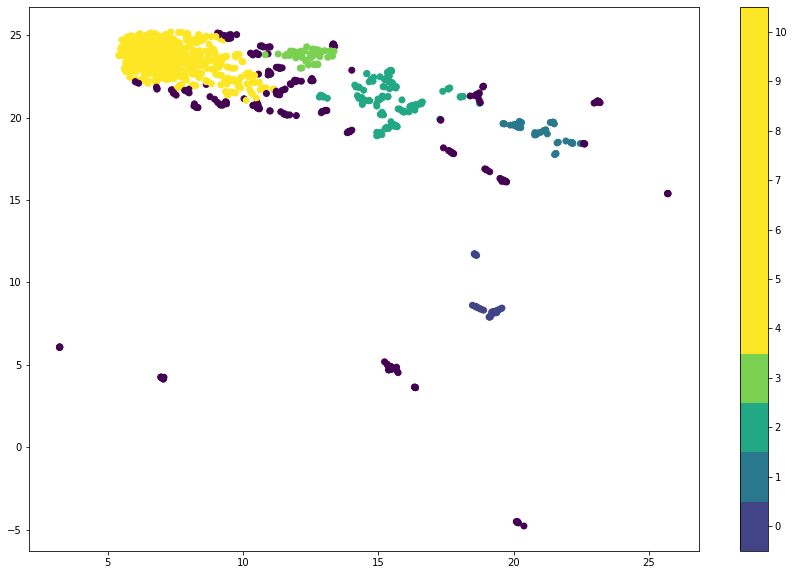

In [55]:
from hdbscan import HDBSCAN
    
hdbscan = HDBSCAN(min_cluster_size=30, gen_min_span_tree=True, metric='braycurtis')

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

hdbscan.labels_.max()

labels = hdbscan.labels_
labels

fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))

from mpl_toolkits.mplot3d import Axes3D



CPU times: user 43.6 ms, sys: 2.41 ms, total: 46 ms
Wall time: 43.9 ms
Silhouette Coefficient: 0.580


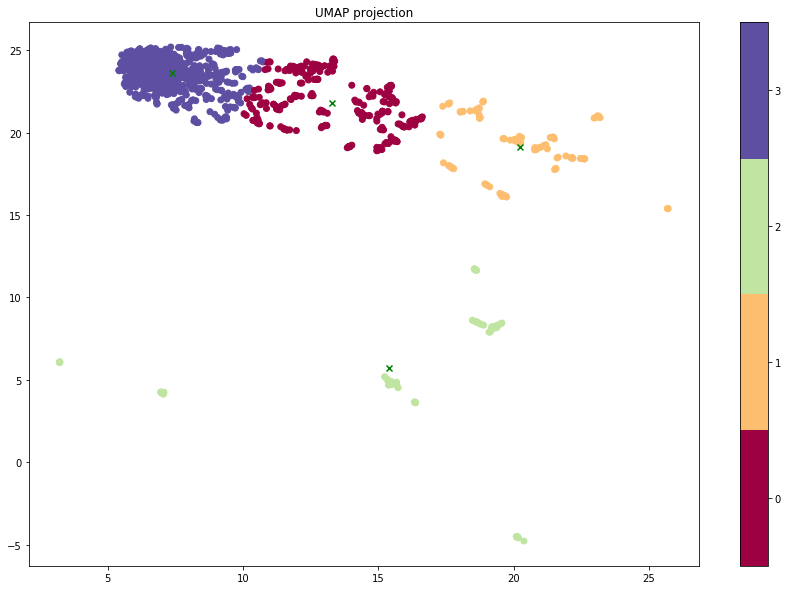

In [56]:
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(embedding)

clusters = km.labels_.tolist()

from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

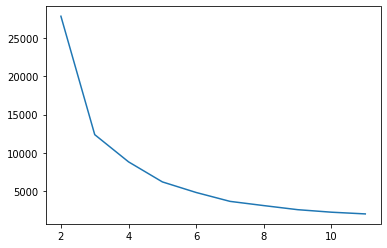

In [57]:
inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

In [61]:
tweets = {'tweet': tweets_user['text'].values,  'cluster': labels}
frame = pd.DataFrame(tweets, index = [labels] , columns = ['tweet', 'cluster'])

frame[frame['cluster']==1].head()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

thank        13.754393
calyx         4.947263
teversall     4.947263
follow        2.204008
book          2.088870
dtype: float64

In [63]:
tweets_user.head()

,id,text,RT,mention,hashtag,date,tokenized
0,1158412428721438720,RT @GottaBernNow: Mass shootings since Sandy H...,1,GottaBernNow,,2019-08-05,"[mass, shooting, sandy, hook, map, https://t.c..."
1,1158051786697166848,"@jethrojones Thanks for following me, @jethroj...",0,"jethrojones, jethrojones",,2019-08-04,"[thanks, follow, love]"
2,1157675759730909186,RT @SchoolMoseley: C is for CELEBRATION! At Mo...,1,SchoolMoseley,,2019-08-03,"[celebration, moseley, block, party, people, j..."
3,1157621927936217089,This why I love highlighting the people at @Le...,0,Learn_Sci,,2019-08-03,"[love, highlight, people, steadfast, commitmen..."
4,1157352479492857856,“I don't care what they do in life as long as ...,0,,,2019-08-02,"[care, life, long, kind, good, people, parent,..."
